In [92]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import nest
nest.set_verbosity("M_ERROR")
%matplotlib inline

We discussed the implementations below in the lecture. Each function is structured as follows:
1. reset the NEST kernel
2. (if applicable) Setup the spike sources
3. Create the neuron(s)
4. Connect the sources and neurons
5. Run the simulation
6. Read out and return the data

For the exercises itself you should not need to adapt these functions. But do take a look at get_membrane and act_fct_neuron_inputrate and verify that you understand what happens where.

In [93]:
nparams={'C_m': 100., 'V_th':0., 'V_reset':-15., 'tau_m': 20., 
         'tau_syn_ex': 5., 'tau_syn_in': 5., 't_ref': 0.5, 'E_L': 0., 
         'V_m': -0.1}

def get_membrane(rate=300., weight=0., bias=0., duration=1000., 
                 inputtype='regular', nparams=nparams):
    """Simulates a single LIF neuron under stimulus
    
    Input:
        rate      float    rate of the input source in Hz
        weight    float    weight of the synaptic connection 
                            between the source and the neuron
        bias      float    value of the leak potential in mV
        duration  float    length of the simulation to run in ms
        inputtype str      selection of regular or Poisson 
                            spike trains (irregular)
        nparams   dict     dictionary of the LIF parameters 
                            cf. https://nest-simulator.readthedocs.io/en/v3.1/models/iaf_psc_exp.html
                            
    Returns:
        times      array   times corresponding to the values for 
                            membranes and currents
        membranes  array   membrane values over time
        currents   tuple   two arrays (excitatory and inhibitory) 
                            of the current values over time
        spiketimes array   spiketimes where the membrane crossed 
                            the threshold
    """
    # clean up NEST
    nest.ResetKernel()

    # create the spike source, if regular, generate the spike train 
    # manually otherwise use the build-in Poisson source
    if inputtype == 'regular':
        # rate is in Hz, spiketimes need to be in ms, and round to 
        # 1 decimal otherwise NEST complains
        spkts = np.round(np.arange(0.1, duration, 1000./rate), 1)
        spikegenerator = nest.Create("spike_generator", 
                                     params={"spike_times": spkts, 
                                             "precise_times": False})
    elif inputtype == 'irregular':
        spikegenerator = nest.Create('poisson_generator')
        nest.SetStatus(spikegenerator, {'rate': rate})
    
    # create the neuron, set the bias and measure spiketimes, membrane 
    # voltages and input currents
    neuron = nest.Create('iaf_psc_exp', params=nparams)
    nest.SetStatus(neuron, {'E_L': bias})
    spikedetector = nest.Create("spike_recorder")
    multimeter = nest.Create("multimeter", 
                             params={"interval": 0.1, 
                                     "record_from": ["V_m", 
                                                     'I_syn_ex', 
                                                     'I_syn_in']})
    nest.Connect(neuron, spikedetector, 'one_to_one')
    nest.Connect(multimeter, neuron, 'one_to_one')

    # connect the spike source to the neuron
    nest.Connect(spikegenerator, neuron, 'one_to_one', 
                 syn_spec={'weight': weight})

    # run the actual simulation
    nest.Simulate(duration)
    
    # retrieve the data
    mdata = nest.GetStatus(multimeter, 'events')
    times = mdata[0]['times']
    membranes = mdata[0]['V_m']
    currents = (mdata[0]['I_syn_ex'], mdata[0]['I_syn_in'])
    spiketimes = np.array(nest.GetStatus(spikedetector, "events"))

    return times, membranes, currents, spiketimes


def act_fct_neuron_bias(b_min = -15., b_max = 50., nneurons = 100, 
                        duration=1000., nparams=nparams):
    """Measures the activation function of a neuron as a function
    of its leak potential
    
    Input:
        b_min     float    lowest leak potential measured [in mV]
        b_max     float    highest leak potential measured [in mV]
        nneurons  int      number of points to test
        duration  float    length of the simulation to run in ms
        nparams   dict     dictionary of the LIF parameters 
        
    Returns:
        weights      array    input weights measured
        outputrates  array    corresponding output rates
    """
    # clean up NEST
    nest.ResetKernel()

    biases = np.linspace(b_min, b_max, nneurons)
    
    # create the neurons, set the biases and measure spiketimes
    neurons = nest.Create('iaf_psc_exp', nneurons, params=nparams)
    nest.SetStatus(neurons, {'E_L': biases})
    spikedetector = nest.Create("spike_recorder", nneurons)
    nest.Connect(neurons, spikedetector, 'one_to_one')

    # run the actual simulation
    nest.Simulate(duration)

    # retrieve the data
    outrates = np.array(nest.GetStatus(spikedetector, "n_events")) * 1000. / duration

    return biases, outrates


def act_fct_neuron_input(winfactor=1., w_min = 0., w_max = 10., rate = 0.0001,
                         nneurons = 100, duration=1000., bias=0., 
                         inputtype='regular', nparams=nparams):
    """Measures the activation function of a neuron as a function
    of its input strength for a fixed rate
    
    Input:
        winfactor float    relative strength of the inhibitory input
        w_min     float    lowest weight measured
        w_max     float    highest weight measured
        rate      float    firing rate of the spike source
        nneurons  int      number of points to test
        duration  float    length of the simulation to run in ms
        bias      float    value of the leak potential in mV
        inputtype str      "regular" for spike train with fixed ISI
                           "irregular" for Poisson spike source
        nparams   dict     dictionary of the LIF parameters 
        
    Returns:
        weights      array    input weights measured
        outputrates  array    corresponding output rates
    """
    # clean up NEST
    nest.ResetKernel()

    weights = np.linspace(w_min, w_max, nneurons)
    
    # create the spike sources, if regular, generate the spike train 
    # manually otherwise use the build-in Poisson source
    if inputtype == 'regular':
        spkts = np.round(np.arange(0.1, duration, 1000./rate), 1)
        spikegenerators = nest.Create("spike_generator", nneurons, 
                                      params={"spike_times": spkts, 
                                              "precise_times": False})
        spikegeneratori = nest.Create("spike_generator", nneurons, 
                                      params={"spike_times": spkts, 
                                              "precise_times": False})
    elif inputtype == 'irregular':
        spikegenerators = nest.Create('poisson_generator', nneurons)
        spikegeneratori = nest.Create('poisson_generator', nneurons)
        nest.SetStatus(spikegenerators, {'rate': rate})
        nest.SetStatus(spikegeneratori, {'rate': rate})

    # create the neurons, set the bias and measure spiketimes
    neurons = nest.Create('iaf_psc_exp', nneurons, params=nparams)
    nest.SetStatus(neurons, {'E_L': bias})
    spikedetector = nest.Create("spike_recorder", nneurons)
    nest.Connect(neurons, spikedetector, 'one_to_one')

    # wire up the network with the generated weights, discount the 
    # inhibitory one by winfactor
    nest.Connect(spikegenerators, neurons, 'one_to_one', 
                 syn_spec={'weight': weights})
    nest.Connect(spikegeneratori, neurons, 'one_to_one', 
                 syn_spec={'weight': -winfactor*weights})

    nest.Simulate(duration)

    outrates = np.array(nest.GetStatus(spikedetector, "n_events")) * 1000. / duration

    return weights, outrates


def act_fct_neuron_inputrate(weight=10., rate_min=100., rate_max=1000., 
                             nneurons = 100, duration=1000., bias=0., 
                             inputtype='regular', nparams=nparams):
    """Measures the activation function of a neuron as a function
    of its input rate
    
    Input:
        weight    float    weight of the synaptic connection 
        rate_min  float    lowest rate measured
        rate_max  float    highest rate measured
        nneurons  int      number of points to test
        duration  float    length of the simulation to run in ms
        bias      float    value of the leak potential in mV
        inputtype str      "regular" for spike train with fixed ISI
                           "irregular" for Poisson spike source
        nparams   dict     dictionary of the LIF parameters 
        
    Returns:
        rates        array    input rates measured
        outputrates  array    corresponding output rates
    """
    # clean up NEST
    nest.ResetKernel()

    rates = np.linspace(rate_min, rate_max, nneurons)
    
    # create the spike source, if regular, generate the spike train 
    # manually otherwise use the build-in Poisson source    
    if inputtype == 'regular':
        spkts = []
        spikegenerators = []
        for rate in rates:
            spkts.append(np.round(np.arange(0.1, duration, 1000./rate), 1))
            spikegenerators.append(nest.Create("spike_generator", 1, 
                                               params={"spike_times": spkts[-1], 
                                                       "precise_times": False}))
    elif inputtype == 'irregular':
        spikegenerators = nest.Create('poisson_generator', nneurons)
        nest.SetStatus(spikegenerators, {'rate': rates})

    # create the neurons, set the bias and measure spiketimes
    neurons = nest.Create('iaf_psc_exp', nneurons, params=nparams)
    nest.SetStatus(neurons, {'E_L': bias})
    spikedetector = nest.Create("spike_recorder", nneurons)
    nest.Connect(neurons, spikedetector, 'one_to_one')
    
    # wire up the network with fixed weight
    for i, source in enumerate(spikegenerators):
        nest.Connect(source, neurons[i], 'one_to_one', 
                     syn_spec={'weight': weight})

    # run the actual simulation
    nest.Simulate(duration)

    # retrieve the data
    outrates = np.array(nest.GetStatus(spikedetector, "n_events")) * 1000. / duration

    return rates, outrates

Show an example trace:

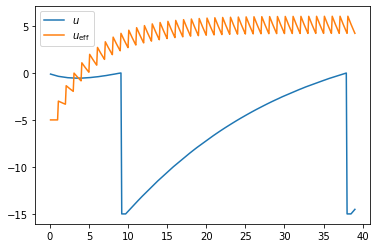

In [94]:
t, v, i, s = get_membrane(rate=1000., bias=-5., weight=10., duration=40., inputtype='regular')
gl = nparams['C_m'] / nparams['tau_m']
plt.plot(t, v, label=r'$u$')
plt.plot(t, i[0]/gl-5., label=r'$u_\mathrm{eff}$')
plt.legend()

For more efficient experiments you can use these interactive widgets to for the different functions

In [113]:
from ipywidgets import interact, FloatSlider
@interact(
    bias=FloatSlider(min=-15, max=50, step=0.1, value=-5),
    rate=FloatSlider(min=0, max=500, step=0.1, value=50),
    weight=FloatSlider(min=0, max=300, step=0.1, value=10),
    duration=FloatSlider(min=0, max=2000, step=1, value=300),
)
def experiment(bias, rate, weight, duration):
    plt.figure()

    t, v, i, s = get_membrane(rate=100., bias=-3., 
                              weight=30., duration=duration, 
                              inputtype='irregular')
    plt.plot(t, v, '-', label=r'$u$')
    plt.plot(t, i[0]/gl+bias, '-', label=r'$u_\mathrm{eff}$')
    if len(s[0]["times"]) > 0:
        plt.plot(s[0]["times"], 4.*np.ones_like(s[0]["times"]), 'v', markersize=15)
    plt.title(f'Number of output spikes: {len(s[0]["times"])}')
    plt.ylabel(r"Voltage [mV]", fontsize=14)
    plt.xlabel("Time [ms]", fontsize=14)
    plt.legend()
    plt.savefig("figures/vout_w30.eps")
    plt.ylim(-10, 5)


interactive(children=(FloatSlider(value=-5.0, description='bias', max=50.0, min=-15.0), FloatSlider(value=50.0…

In [96]:
from ipywidgets import interact, FloatSlider
@interact(
    b_min=FloatSlider(min=-15, max=10, step=0.1, value=-5),
    b_max=FloatSlider(min=0, max=50, step=0.1, value=15),
    duration=FloatSlider(min=0, max=2000, step=1, value=100),
)
def experiment(b_min, b_max, duration):
    plt.figure()
    biases, outrates = act_fct_neuron_bias(b_min = b_min, b_max = b_max, nneurons = 100, duration=duration)
    plt.plot(biases, outrates)
    plt.xlabel("Bias", fontsize=14)
    plt.ylabel("Outrate", fontsize=14)
    plt.savefig("figures/outrate_" + str(duration) + "ms.eps")
    plt.show()

interactive(children=(FloatSlider(value=-5.0, description='b_min', max=10.0, min=-15.0), FloatSlider(value=15.…

In [97]:
@interact(
    winfactor=FloatSlider(min=0, max=1, step=0.1, value=0.),
    w_min=FloatSlider(min=0, max=100, step=0.1, value=5),
    w_max=FloatSlider(min=15, max=100, step=0.1, value=15),
    rate=FloatSlider(min=0, max=2000, step=0.1, value=1000),
    bias=FloatSlider(min=-15, max=30, step=0.1, value=-5),
    duration=FloatSlider(min=0, max=2000, step=1, value=100),
)
def experiment(winfactor, w_min, w_max, rate, bias, duration):
    plt.figure()
    weights, outrates = act_fct_neuron_input(winfactor=winfactor, w_min=w_min, w_max=w_max, 
                                             rate=rate, bias=bias, 
                                             duration=duration, inputtype='irregular')
    plt.plot(weights, outrates)
    plt.title(f'number of non-monotonicities: {np.sum(np.diff(outrates)<0.)}')
    plt.ylim(0, None)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='winfactor', max=1.0), FloatSlider(value=5.0, descrip…

In [98]:
@interact(
    weight=FloatSlider(min=0, max=100, step=0.1, value=10),
    rate_min=FloatSlider(min=5, max=600, step=0.1, value=500),
    rate_max=FloatSlider(min=0, max=800, step=0.1, value=505),
    bias=FloatSlider(min=-15, max=30, step=0.1, value=-5),

    duration=FloatSlider(min=10, max=10000, step=1, value=1000.),

)
def experiment(weight, rate_min, rate_max, bias, duration):
    # 10, 500, 505, -5
    plt.figure()
    weights, outrates = act_fct_neuron_inputrate(weight=weight, nneurons=100, 
                                                 rate_min=rate_min, rate_max=rate_max,
                                                 duration=duration,
                                                 bias=bias, inputtype='regular')
    plt.plot(weights, outrates)
    plt.title(f'number of non-monotonicities: {np.sum(np.diff(outrates)<0.)}')
    plt.ylim(0, None)
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='weight'), FloatSlider(value=500.0, description='rat…

In [99]:
@interact(
    weight=FloatSlider(min=0, max=100, step=0.1, value=10),
    rate_min=FloatSlider(min=0, max=600, step=0.1, value=10),
    rate_max=FloatSlider(min=0, max=1200, step=0.1, value=505),
    bias=FloatSlider(min=-15, max=30, step=0.1, value=-5),
    duration=FloatSlider(min=200, max=5000, step=0.1, value=500),
)
def experiment(weight, rate_min, rate_max, bias, duration):
    plt.figure()
    weights, outrates = act_fct_neuron_inputrate(weight=weight, nneurons=100, 
                                                 rate_min=rate_min, rate_max=rate_max, 
                                                 bias=bias, inputtype='irregular', 
                                                 duration=duration)
    plt.plot(weights, outrates)
    plt.title(f'number of non-monotonicities: {np.sum(np.diff(outrates)<0.)}')
    plt.ylim(0, None)
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='weight'), FloatSlider(value=10.0, description='rate…